In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate, RZGate

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, coherent_unitary_error

from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeBrooklynV2

# from qiskit.quantum_info import Kraus, SuperOp

# Import from Qiskit Aer noise module
# import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle

from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import GetGHZCircuitsForModel
from circuits.pqc_circuits import qiskit_PQC_RZRX_unique
from circuits.modify_circuits import append_pqc_to_quantum_circuit

from models.noise_models import BitPhaseFlipNoise
from models.qiskit_models import ScaledQiskitQuantumModel

from simulator.simulate import get_ideal_data, get_ideal_data_superpos

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 2
INPUT_BITS = '10101'
EPOCHS = 25

ideal_sim = AerSimulator(device=aer_device)

pqc_arch = qiskit_PQC_RZRX_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = ScaledQiskitQuantumModel(
    num_params=NUM_QUBITS*2, simulator=ideal_sim, num_shots=NUM_SHOTS, pqc_arch_func=pqc_arch
)

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
)



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=int(100000), device=aer_device)
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 100000/100000 [02:36<00:00, 639.77it/s]

32


In [9]:
param_list = []
loss_list_epoch = []
for i in range(EPOCHS):
    print(f'Starting Epoch {i+1}')
    pqc_model.train()
    ctr = 0
    loss_list = [0]
    shuffle(ideal_data)
    data_iterator_tqdm = tqdm(ideal_data)
    for params, ideal in data_iterator_tqdm:
        ctr += 1
        optimizer.zero_grad()

        measured = pqc_model(circuit=ghz_circuit_gen.get_noisy_model_circuit_params(params))
        # print(ideal)
        ideal = ideal.float().to(torch_device)
        measured = measured.float().to(torch_device)
        
        loss = loss_fn(ideal, measured)

        loss.backward()
        optimizer.step()

        param_values = pqc_model.raw_params.detach().cpu().numpy().copy()
        param_list.append(param_values)
        loss_list.append(loss.item())
        data_iterator_tqdm.set_postfix_str(f"Loss: {loss}")
        # print(param_list)


        # if (ctr) % (len(ideal_data) // 10) == 0:
            
    print(f'Loss: {np.mean(loss_list):.4f}, Params: {pqc_model.raw_params}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')
    param_arr = np.array(param_list).transpose()
    print(param_arr)    
    loss_list_epoch.append(np.mean(loss_list))

    

Starting Epoch 1


100%|██████████| 100000/100000 [20:05<00:00, 82.98it/s, Loss: 5750.0]    


Loss: 8281.9013, Params: Parameter containing:
tensor([-0.4070, -0.2009,  0.6917, -0.0728, -0.2449,  0.3766, -0.0539, -0.0559,
        -0.0558,  0.2538], requires_grad=True)
[[-1.1078238  -1.1078128  -1.1078017  ... -0.4070073  -0.40700322
  -0.40699914]
 [-0.54687464 -0.54686916 -0.5468637  ... -0.20091863 -0.20091662
  -0.2009146 ]
 [ 1.8828464   1.8828275   1.8828087  ...  0.6917451   0.6917382
   0.6917313 ]
 ...
 [-0.15209253 -0.15209101 -0.15208949 ... -0.05587799 -0.05587743
  -0.05587687]
 [-0.15185457 -0.15185305 -0.15185153 ... -0.05579051 -0.05578995
  -0.05578939]
 [ 0.6909076   0.6909007   0.69089377 ...  0.25383434  0.2538318
   0.25382927]]
Starting Epoch 2


100%|██████████| 100000/100000 [18:30<00:00, 90.01it/s, Loss: 1896.1875] 


Loss: 5185.7077, Params: Parameter containing:
tensor([-0.1495, -0.0738,  0.2541, -0.0267, -0.0900,  0.1384, -0.0198, -0.0205,
        -0.0205,  0.0933], requires_grad=True)
[[-1.1078238  -1.1078128  -1.1078017  ... -0.14952607 -0.14952458
  -0.1495231 ]
 [-0.54687464 -0.54686916 -0.5468637  ... -0.07381395 -0.07381321
  -0.07381248]
 [ 1.8828464   1.8828275   1.8828087  ...  0.25413352  0.254131
   0.25412846]
 ...
 [-0.15209253 -0.15209101 -0.15208949 ... -0.02052851 -0.02052831
  -0.0205281 ]
 [-0.15185457 -0.15185305 -0.15185153 ... -0.02049644 -0.02049624
  -0.02049603]
 [ 0.6909076   0.6909007   0.69089377 ...  0.09325451  0.09325358
   0.09325264]]
Starting Epoch 3


100%|██████████| 100000/100000 [16:26<00:00, 101.33it/s, Loss: 764.875]  


Loss: 3003.2809, Params: Parameter containing:
tensor([-0.0549, -0.0271,  0.0934, -0.0098, -0.0331,  0.0508, -0.0073, -0.0075,
        -0.0075,  0.0343], requires_grad=True)
[[-1.1078238  -1.1078128  -1.1078017  ... -0.05493386 -0.05493331
  -0.05493275]
 [-0.54687464 -0.54686916 -0.5468637  ... -0.02711803 -0.02711776
  -0.02711749]
 [ 1.8828464   1.8828275   1.8828087  ...  0.09336448  0.09336355
   0.09336262]
 ...
 [-0.15209253 -0.15209101 -0.15208949 ... -0.00754187 -0.0075418
  -0.00754172]
 [-0.15185457 -0.15185305 -0.15185153 ... -0.00753007 -0.00752999
  -0.00752992]
 [ 0.6909076   0.6909007   0.69089377 ...  0.03426026  0.03425992
   0.03425957]]
Starting Epoch 4


100%|██████████| 100000/100000 [17:58<00:00, 92.72it/s, Loss: 594.3125]  


Loss: 2303.1816, Params: Parameter containing:
tensor([-0.0202, -0.0100,  0.0343, -0.0036, -0.0121,  0.0187, -0.0027, -0.0028,
        -0.0028,  0.0126], requires_grad=True)
[[-1.1078238  -1.1078128  -1.1078017  ... -0.0201816  -0.0201814
  -0.02018119]
 [-0.54687464 -0.54686916 -0.5468637  ... -0.0099627  -0.0099626
  -0.0099625 ]
 [ 1.8828464   1.8828275   1.8828087  ...  0.03430073  0.03430038
   0.03430004]
 ...
 [-0.15209253 -0.15209101 -0.15208949 ... -0.00277075 -0.00277072
  -0.0027707 ]
 [-0.15185457 -0.15185305 -0.15185153 ... -0.00276642 -0.00276639
  -0.00276636]
 [ 0.6909076   0.6909007   0.69089377 ...  0.0125866   0.01258647
   0.01258635]]
Starting Epoch 5


100%|██████████| 100000/100000 [17:32<00:00, 95.02it/s, Loss: 7893.4375] 


Loss: 2084.9712, Params: Parameter containing:
tensor([-0.0074, -0.0037,  0.0126, -0.0013, -0.0045,  0.0069, -0.0010, -0.0010,
        -0.0010,  0.0046], requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -7.4144341e-03
  -7.4143601e-03 -7.4142860e-03]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -3.6601217e-03
  -3.6600851e-03 -3.6600486e-03]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  1.2601444e-02
   1.2601318e-02  1.2601192e-02]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -1.0179160e-03
  -1.0179058e-03 -1.0178955e-03]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -1.0163236e-03
  -1.0163134e-03 -1.0163033e-03]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  4.6240715e-03
   4.6240254e-03  4.6239793e-03]]
Starting Epoch 6


100%|██████████| 100000/100000 [16:24<00:00, 101.53it/s, Loss: 1052.4375]


Loss: 2011.8187, Params: Parameter containing:
tensor([-0.0027, -0.0013,  0.0046, -0.0005, -0.0016,  0.0025, -0.0004, -0.0004,
        -0.0004,  0.0017], requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -2.7239420e-03
  -2.7239148e-03 -2.7238876e-03]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -1.3446641e-03
  -1.3446506e-03 -1.3446371e-03]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  4.6295398e-03
   4.6294932e-03  4.6294467e-03]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -3.7396839e-04
  -3.7396463e-04 -3.7396088e-04]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -3.7338142e-04
  -3.7337770e-04 -3.7337397e-04]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  1.6988222e-03
   1.6988053e-03  1.6987883e-03]]
Starting Epoch 7


100%|██████████| 100000/100000 [17:20<00:00, 96.12it/s, Loss: 2502.5625] 


Loss: 1985.5428, Params: Parameter containing:
tensor([-0.0010, -0.0005,  0.0017, -0.0002, -0.0006,  0.0009, -0.0001, -0.0001,
        -0.0001,  0.0006], requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -1.0007318e-03
  -1.0007218e-03 -1.0007118e-03]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -4.9400952e-04
  -4.9400458e-04 -4.9399963e-04]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  1.7008284e-03
   1.7008114e-03  1.7007944e-03]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -1.3738852e-04
  -1.3738713e-04 -1.3738575e-04]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -1.3717380e-04
  -1.3717244e-04 -1.3717107e-04]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  6.2411465e-04
   6.2410842e-04  6.2410219e-04]]
Starting Epoch 8


100%|██████████| 100000/100000 [16:47<00:00, 99.26it/s, Loss: 6222.125]  


Loss: 1976.2691, Params: Parameter containing:
tensor([-3.6764e-04, -1.8149e-04,  6.2484e-04, -6.5716e-05, -2.2123e-04,
         3.4022e-04, -4.8649e-05, -5.0474e-05, -5.0395e-05,  2.2929e-04],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -3.6764878e-04
  -3.6764512e-04 -3.6764145e-04]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -1.8149042e-04
  -1.8148861e-04 -1.8148679e-04]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  6.2484993e-04
   6.2484370e-04  6.2483747e-04]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -5.0474795e-05
  -5.0474289e-05 -5.0473784e-05]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -5.0395647e-05
  -5.0395141e-05 -5.0394636e-05]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  2.2929048e-04
   2.2928818e-04  2.2928588e-04]]
Starting Epoch 9


100%|██████████| 100000/100000 [16:36<00:00, 100.39it/s, Loss: 1267.375] 


Loss: 1972.9697, Params: Parameter containing:
tensor([-1.3507e-04, -6.6675e-05,  2.2956e-04, -2.4143e-05, -8.1278e-05,
         1.2499e-04, -1.7873e-05, -1.8543e-05, -1.8514e-05,  8.4236e-05],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -1.3506900e-04
  -1.3506765e-04 -1.3506629e-04]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -6.6676352e-05
  -6.6675682e-05 -6.6675013e-05]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  2.2956191e-04
   2.2955961e-04  2.2955731e-04]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -1.8543575e-05
  -1.8543389e-05 -1.8543204e-05]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -1.8514533e-05
  -1.8514347e-05 -1.8514162e-05]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  8.4237421e-05
   8.4236577e-05  8.4235733e-05]]
Starting Epoch 10


100%|██████████| 100000/100000 [18:36<00:00, 89.60it/s, Loss: 952.6875]  


Loss: 1970.8620, Params: Parameter containing:
tensor([-4.9621e-05, -2.4495e-05,  8.4335e-05, -8.8697e-06, -2.9860e-05,
         4.5919e-05, -6.5661e-06, -6.8125e-06, -6.8018e-06,  3.0947e-05],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -4.9621827e-05
  -4.9621329e-05 -4.9620830e-05]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -2.4495814e-05
  -2.4495568e-05 -2.4495323e-05]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  8.4337044e-05
   8.4336200e-05  8.4335355e-05]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -6.8126010e-06
  -6.8125328e-06 -6.8124646e-06]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -6.8019258e-06
  -6.8018576e-06 -6.8017894e-06]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  3.0947376e-05
   3.0947067e-05  3.0946758e-05]]
Starting Epoch 11


100%|██████████| 100000/100000 [19:29<00:00, 85.49it/s, Loss: 1704.625]  


Loss: 1969.7622, Params: Parameter containing:
tensor([-1.8230e-05, -8.9992e-06,  3.0983e-05, -3.2586e-06, -1.0970e-05,
         1.6870e-05, -2.4123e-06, -2.5028e-06, -2.4989e-06,  1.1369e-05],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -1.8230183e-05
  -1.8230001e-05 -1.8229819e-05]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -8.9993491e-06
  -8.9992591e-06 -8.9991690e-06]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  3.0983880e-05
   3.0983570e-05  3.0983261e-05]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -2.5028273e-06
  -2.5028023e-06 -2.5027773e-06]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -2.4989124e-06
  -2.4988874e-06 -2.4988624e-06]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  1.1369541e-05
   1.1369428e-05  1.1369314e-05]]
Starting Epoch 12


100%|██████████| 100000/100000 [20:34<00:00, 80.97it/s, Loss: 480.6875]  


Loss: 1971.1489, Params: Parameter containing:
tensor([-6.6973e-06, -3.3061e-06,  1.1383e-05, -1.1971e-06, -4.0302e-06,
         6.1977e-06, -8.8623e-07, -9.1948e-07, -9.1804e-07,  4.1769e-06],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -6.6974712e-06
  -6.6974044e-06 -6.6973375e-06]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -3.3061979e-06
  -3.3061647e-06 -3.3061315e-06]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  1.1382961e-05
   1.1382847e-05  1.1382734e-05]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -9.1949914e-07
  -9.1948993e-07 -9.1948073e-07]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -9.1805794e-07
  -9.1804873e-07 -9.1803952e-07]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  4.1769831e-06
   4.1769413e-06  4.1768994e-06]]
Starting Epoch 13


100%|██████████| 100000/100000 [21:57<00:00, 75.91it/s, Loss: 4524.25]   


Loss: 1970.1149, Params: Parameter containing:
tensor([-2.4605e-06, -1.2146e-06,  4.1818e-06, -4.3981e-07, -1.4806e-06,
         2.2769e-06, -3.2559e-07, -3.3780e-07, -3.3727e-07,  1.5345e-06],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -2.4605345e-06
  -2.4605099e-06 -2.4604853e-06]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -1.2146450e-06
  -1.2146328e-06 -1.2146206e-06]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  4.1819217e-06
   4.1818798e-06  4.1818380e-06]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -3.3780790e-07
  -3.3780452e-07 -3.3780114e-07]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -3.3727869e-07
  -3.3727531e-07 -3.3727193e-07]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  1.5345508e-06
   1.5345355e-06  1.5345202e-06]]
Starting Epoch 14


100%|██████████| 100000/100000 [18:34<00:00, 89.75it/s, Loss: 625.25]    


Loss: 1970.4894, Params: Parameter containing:
tensor([-9.0395e-07, -4.4623e-07,  1.5363e-06, -1.6158e-07, -5.4396e-07,
         8.3651e-07, -1.1961e-07, -1.2410e-07, -1.2391e-07,  5.6375e-07],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -9.0396367e-07
  -9.0395463e-07 -9.0394559e-07]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -4.4623997e-07
  -4.4623550e-07 -4.4623104e-07]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  1.5363627e-06
   1.5363473e-06  1.5363320e-06]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -1.2410341e-07
  -1.2410217e-07 -1.2410094e-07]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -1.2390994e-07
  -1.2390871e-07 -1.2390747e-07]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  5.6376564e-07
   5.6376001e-07  5.6375438e-07]]
Starting Epoch 15


100%|██████████| 100000/100000 [16:12<00:00, 102.80it/s, Loss: 756.4375] 


Loss: 1970.7638, Params: Parameter containing:
tensor([-3.3209e-07, -1.6394e-07,  5.6442e-07, -5.9362e-08, -1.9984e-07,
         3.0732e-07, -4.3945e-08, -4.5593e-08, -4.5522e-08,  2.0711e-07],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -3.3210100e-07
  -3.3209767e-07 -3.3209434e-07]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -1.6393955e-07
  -1.6393790e-07 -1.6393625e-07]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  5.6442985e-07
   5.6442423e-07  5.6441860e-07]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -4.5593715e-08
  -4.5593257e-08 -4.5592799e-08]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -4.5522526e-08
  -4.5522071e-08 -4.5521617e-08]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  2.0711899e-07
   2.0711691e-07  2.0711484e-07]]
Starting Epoch 16


100%|██████████| 100000/100000 [16:19<00:00, 102.13it/s, Loss: 1303.8125]


Loss: 1968.7997, Params: Parameter containing:
tensor([-1.2201e-07, -6.0228e-08,  2.0736e-07, -2.1809e-08, -7.3418e-08,
         1.1290e-07, -1.6144e-08, -1.6750e-08, -1.6724e-08,  7.6090e-08],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -1.2200842e-07
  -1.2200719e-07 -1.2200597e-07]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -6.0229162e-08
  -6.0228558e-08 -6.0227954e-08]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  2.0736391e-07
   2.0736184e-07  2.0735976e-07]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -1.6750313e-08
  -1.6750146e-08 -1.6749979e-08]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -1.6724186e-08
  -1.6724020e-08 -1.6723853e-08]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  7.6091780e-08
   7.6091020e-08  7.6090259e-08]]
Starting Epoch 17


100%|██████████| 100000/100000 [16:20<00:00, 102.03it/s, Loss: 96.4375]  


Loss: 1969.3326, Params: Parameter containing:
tensor([-4.4823e-08, -2.2127e-08,  7.6180e-08, -8.0120e-09, -2.6973e-08,
         4.1479e-08, -5.9312e-09, -6.1537e-09, -6.1441e-09,  2.7954e-08],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -4.4823604e-08
  -4.4823157e-08 -4.4822709e-08]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -2.2127118e-08
  -2.2126896e-08 -2.2126674e-08]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  7.6181529e-08
   7.6180768e-08  7.6180008e-08]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -6.1538348e-09
  -6.1537730e-09 -6.1537113e-09]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -6.1441741e-09
  -6.1441123e-09 -6.1440506e-09]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  2.7954831e-08
   2.7954551e-08  2.7954270e-08]]
Starting Epoch 18


100%|██████████| 100000/100000 [16:41<00:00, 99.86it/s, Loss: 1477.5625] 


Loss: 1971.1248, Params: Parameter containing:
tensor([-1.6467e-08, -8.1289e-09,  2.7987e-08, -2.9435e-09, -9.9093e-09,
         1.5239e-08, -2.1790e-09, -2.2608e-09, -2.2572e-09,  1.0270e-08],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -1.6467474e-08
  -1.6467309e-08 -1.6467144e-08]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -8.1290903e-09
  -8.1290086e-09 -8.1289269e-09]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  2.7987959e-08
   2.7987678e-08  2.7987397e-08]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -2.2608171e-09
  -2.2607944e-09 -2.2607718e-09]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -2.2572728e-09
  -2.2572502e-09 -2.2572275e-09]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  1.0270137e-08
   1.0270034e-08  1.0269931e-08]]
Starting Epoch 19


100%|██████████| 100000/100000 [16:56<00:00, 98.38it/s, Loss: 5116.0]    


Loss: 1971.3428, Params: Parameter containing:
tensor([-6.0497e-09, -2.9864e-09,  1.0282e-08, -1.0814e-09, -3.6405e-09,
         5.5984e-09, -8.0053e-10, -8.3057e-10, -8.2927e-10,  3.7730e-09],
       requires_grad=True)
[[-1.10782385e+00 -1.10781276e+00 -1.10780168e+00 ... -6.04985084e-09
  -6.04979045e-09 -6.04973005e-09]
 [-5.46874642e-01 -5.46869159e-01 -5.46863675e-01 ... -2.98650260e-09
  -2.98647262e-09 -2.98644265e-09]
 [ 1.88284636e+00  1.88282752e+00  1.88280869e+00 ...  1.02822995e-08
   1.02821964e-08  1.02820934e-08]
 ...
 [-1.52092531e-01 -1.52091011e-01 -1.52089491e-01 ... -8.30585878e-10
  -8.30577551e-10 -8.30569225e-10]
 [-1.51854575e-01 -1.51853055e-01 -1.51851535e-01 ... -8.29282754e-10
  -8.29274427e-10 -8.29266100e-10]
 [ 6.90907598e-01  6.90900683e-01  6.90893769e-01 ...  3.77308407e-09
   3.77304632e-09  3.77300857e-09]]
Starting Epoch 20


100%|██████████| 100000/100000 [16:20<00:00, 101.98it/s, Loss: 1040.0625]


Loss: 1971.2320, Params: Parameter containing:
tensor([-2.2226e-09, -1.0972e-09,  3.7775e-09, -3.9728e-10, -1.3375e-09,
         2.0568e-09, -2.9410e-10, -3.0514e-10, -3.0466e-10,  1.3861e-09],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -2.2226163e-09
  -2.2225941e-09 -2.2225719e-09]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -1.0971932e-09
  -1.0971822e-09 -1.0971712e-09]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  3.7775401e-09
   3.7775023e-09  3.7774646e-09]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -3.0514305e-10
  -3.0514000e-10 -3.0513694e-10]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -3.0466518e-10
  -3.0466213e-10 -3.0465908e-10]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  1.3861662e-09
   1.3861523e-09  1.3861384e-09]]
Starting Epoch 21


100%|██████████| 100000/100000 [16:49<00:00, 99.05it/s, Loss: 2646.4375] 


Loss: 1969.3622, Params: Parameter containing:
tensor([-8.1654e-10, -4.0308e-10,  1.3878e-09, -1.4596e-10, -4.9136e-10,
         7.5562e-10, -1.0805e-10, -1.1210e-10, -1.1193e-10,  5.0924e-10],
       requires_grad=True)
[[-1.10782385e+00 -1.10781276e+00 -1.10780168e+00 ... -8.16552548e-10
  -8.16544388e-10 -8.16536228e-10]
 [-5.46874642e-01 -5.46869159e-01 -5.46863675e-01 ... -4.03088590e-10
  -4.03084566e-10 -4.03080541e-10]
 [ 1.88284636e+00  1.88282752e+00  1.88280869e+00 ...  1.38780420e-09
   1.38779033e-09  1.38777645e-09]
 ...
 [-1.52092531e-01 -1.52091011e-01 -1.52089491e-01 ... -1.12104451e-10
  -1.12103327e-10 -1.12102203e-10]
 [-1.51854575e-01 -1.51853055e-01 -1.51851535e-01 ... -1.11928515e-10
  -1.11927391e-10 -1.11926267e-10]
 [ 6.90907598e-01  6.90900683e-01  6.90893769e-01 ...  5.09253639e-10
   5.09248532e-10  5.09243425e-10]]
Starting Epoch 22


100%|██████████| 100000/100000 [16:58<00:00, 98.17it/s, Loss: 314.0]     


Loss: 1971.7370, Params: Parameter containing:
tensor([-2.9998e-10, -1.4809e-10,  5.0985e-10, -5.3622e-11, -1.8052e-10,
         2.7760e-10, -3.9695e-11, -4.1184e-11, -4.1120e-11,  1.8709e-10],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -2.9998729e-10
  -2.9998429e-10 -2.9998129e-10]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -1.4808833e-10
  -1.4808685e-10 -1.4808536e-10]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  5.0985649e-10
   5.0985138e-10  5.0984628e-10]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -4.1185243e-11
  -4.1184830e-11 -4.1184417e-11]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -4.1120614e-11
  -4.1120201e-11 -4.1119788e-11]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  1.8709129e-10
   1.8708941e-10  1.8708754e-10]]
Starting Epoch 23


100%|██████████| 100000/100000 [16:29<00:00, 101.03it/s, Loss: 889.8125] 


Loss: 1970.4857, Params: Parameter containing:
tensor([-1.1021e-10, -5.4404e-11,  1.8731e-10, -1.9700e-11, -6.6319e-11,
         1.0199e-10, -1.4583e-11, -1.5130e-11, -1.5107e-11,  6.8733e-11],
       requires_grad=True)
[[-1.10782385e+00 -1.10781276e+00 -1.10780168e+00 ... -1.10210591e-10
  -1.10209487e-10 -1.10208384e-10]
 [-5.46874642e-01 -5.46869159e-01 -5.46863675e-01 ... -5.44052373e-11
  -5.44046926e-11 -5.44041479e-11]
 [ 1.88284636e+00  1.88282752e+00  1.88280869e+00 ...  1.87312443e-10
   1.87310570e-10  1.87308696e-10]
 ...
 [-1.52092531e-01 -1.52091011e-01 -1.52089491e-01 ... -1.51306676e-11
  -1.51305166e-11 -1.51303657e-11]
 [-1.51854575e-01 -1.51853055e-01 -1.51851535e-01 ... -1.51070458e-11
  -1.51068949e-11 -1.51067440e-11]
 [ 6.90907598e-01  6.90900683e-01  6.90893769e-01 ...  6.87340324e-11
   6.87333454e-11  6.87326585e-11]]
Starting Epoch 24


100%|██████████| 100000/100000 [17:30<00:00, 95.23it/s, Loss: 1289.1875] 


Loss: 1971.4869, Params: Parameter containing:
tensor([-4.0489e-11, -1.9987e-11,  6.8814e-11, -7.2373e-12, -2.4365e-11,
         3.7468e-11, -5.3577e-12, -5.5587e-12, -5.5500e-12,  2.5251e-11],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -4.0489428e-11
  -4.0489022e-11 -4.0488616e-11]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -1.9987434e-11
  -1.9987234e-11 -1.9987035e-11]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  6.8815120e-11
   6.8814433e-11  6.8813746e-11]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -5.5587653e-12
  -5.5587097e-12 -5.5586542e-12]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -5.5500799e-12
  -5.5500244e-12 -5.5499689e-12]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  2.5251740e-11
   2.5251487e-11  2.5251233e-11]]
Starting Epoch 25


100%|██████████| 100000/100000 [19:49<00:00, 84.05it/s, Loss: 1065.0]    


Loss: 1970.8839, Params: Parameter containing:
tensor([-1.4875e-11, -7.3429e-12,  2.5281e-11, -2.6589e-12, -8.9511e-12,
         1.3765e-11, -1.9683e-12, -2.0422e-12, -2.0390e-12,  9.2769e-12],
       requires_grad=True)
[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -1.4875141e-11
  -1.4874992e-11 -1.4874843e-11]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -7.3430680e-12
  -7.3429943e-12 -7.3429205e-12]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  2.5281638e-11
   2.5281385e-11  2.5281131e-11]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -2.0421941e-12
  -2.0421737e-12 -2.0421533e-12]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -2.0390044e-12
  -2.0389840e-12 -2.0389636e-12]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  9.2770644e-12
   9.2769716e-12  9.2768787e-12]]


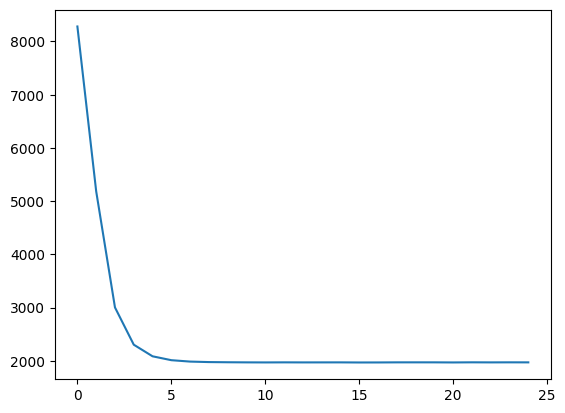

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
param_arr = np.array(param_list).transpose()
print(param_arr)

[[-1.1078238e+00 -1.1078128e+00 -1.1078017e+00 ... -1.4875141e-11
  -1.4874992e-11 -1.4874843e-11]
 [-5.4687464e-01 -5.4686916e-01 -5.4686368e-01 ... -7.3430680e-12
  -7.3429943e-12 -7.3429205e-12]
 [ 1.8828464e+00  1.8828275e+00  1.8828087e+00 ...  2.5281638e-11
   2.5281385e-11  2.5281131e-11]
 ...
 [-1.5209253e-01 -1.5209101e-01 -1.5208949e-01 ... -2.0421941e-12
  -2.0421737e-12 -2.0421533e-12]
 [-1.5185457e-01 -1.5185305e-01 -1.5185153e-01 ... -2.0390044e-12
  -2.0389840e-12 -2.0389636e-12]
 [ 6.9090760e-01  6.9090068e-01  6.9089377e-01 ...  9.2770644e-12
   9.2769716e-12  9.2768787e-12]]


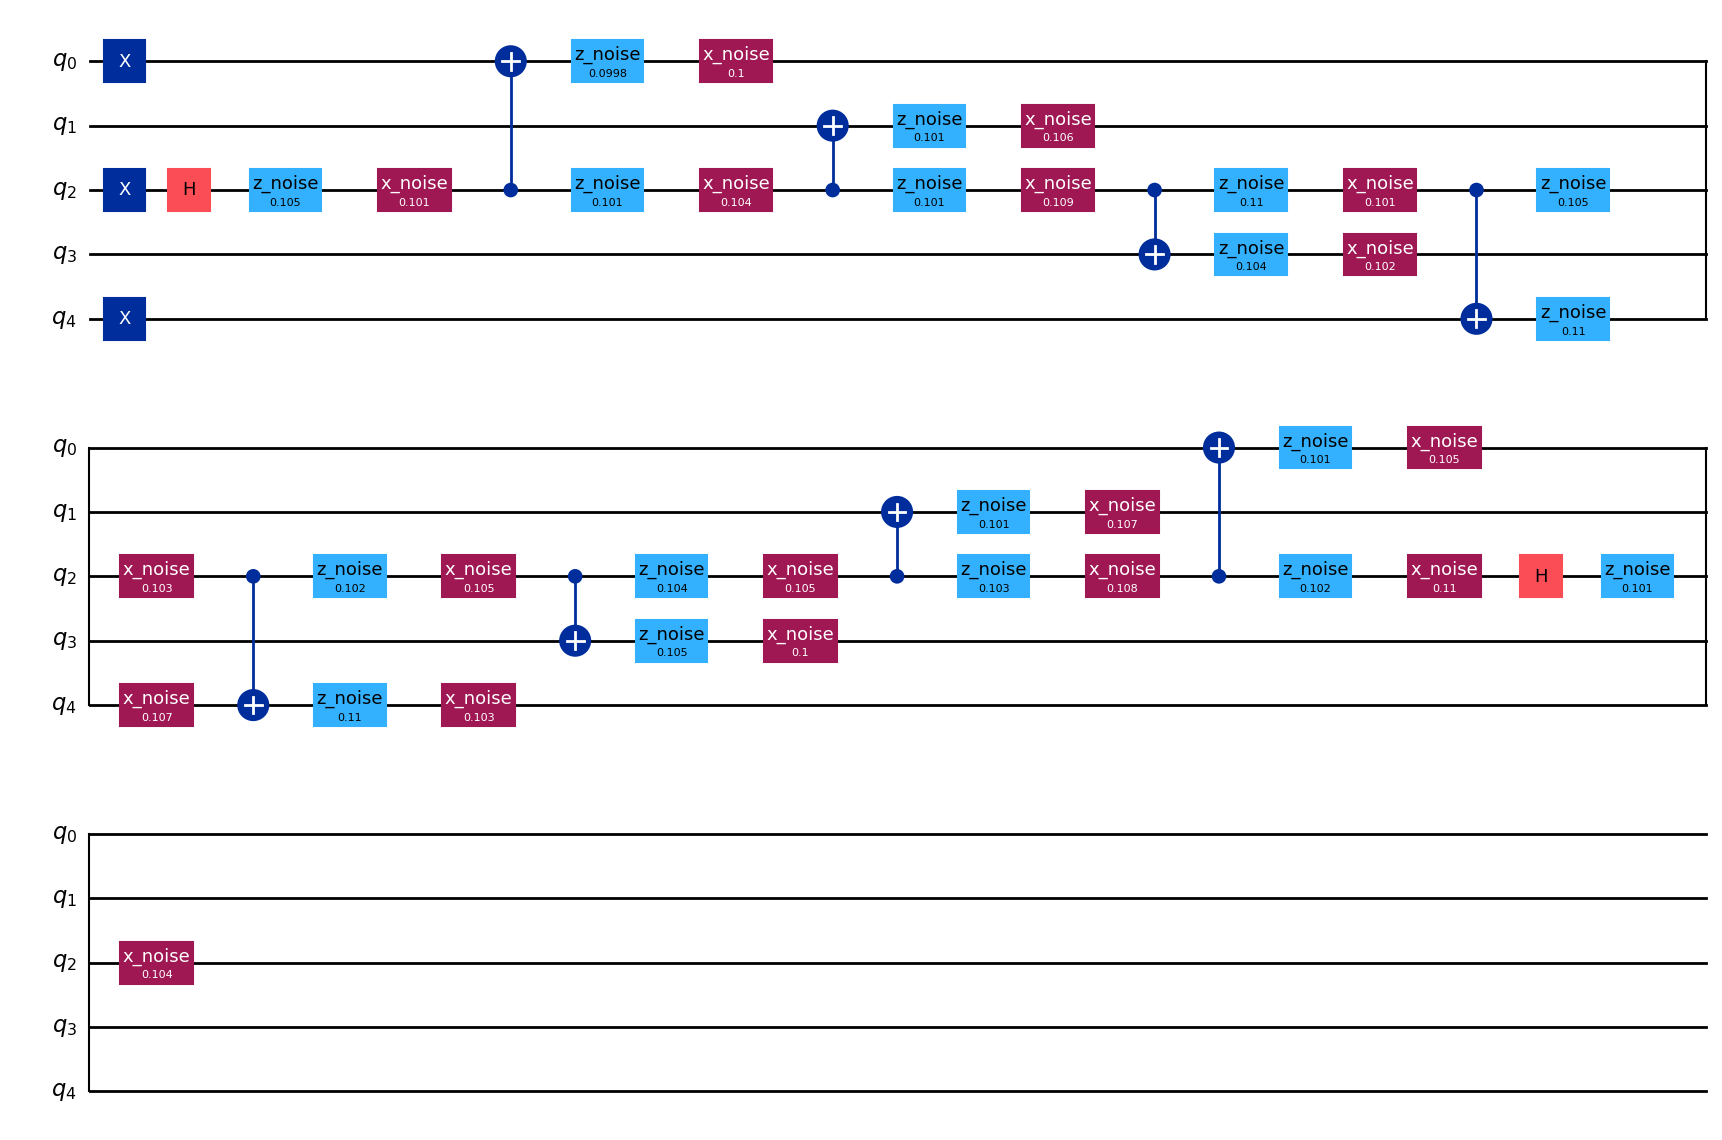

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

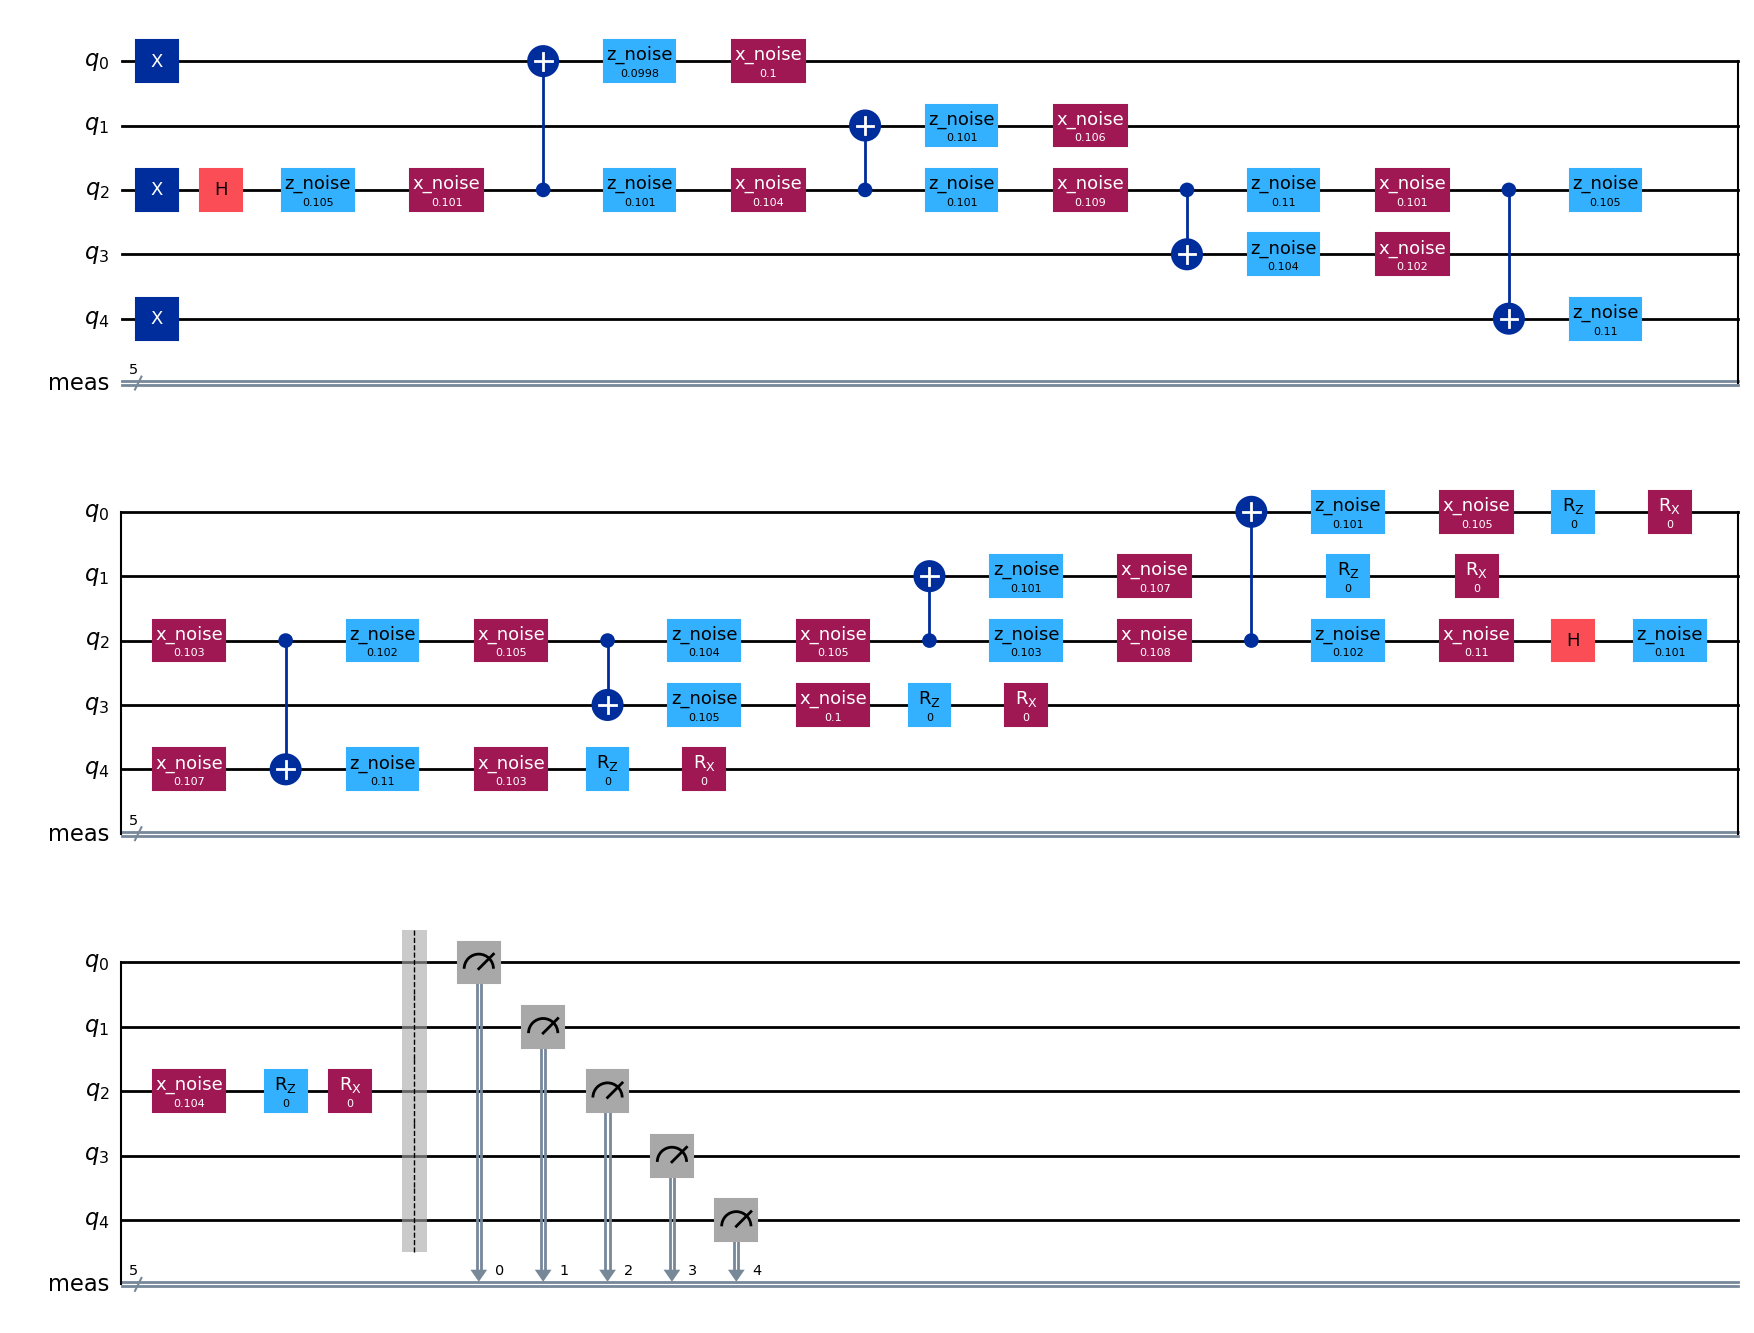

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, pqc_arch)
noisy_model_circ_pqc.draw('mpl')

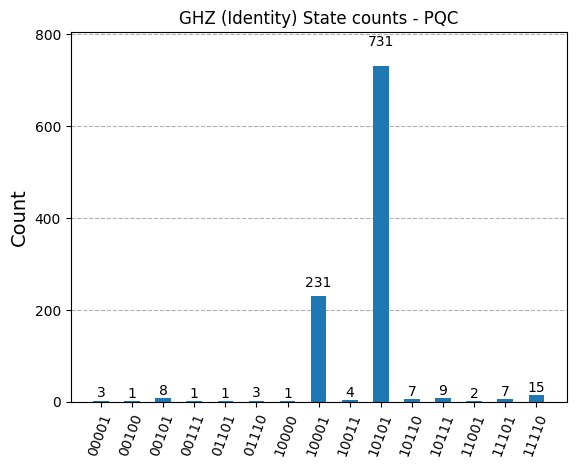

In [14]:
transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

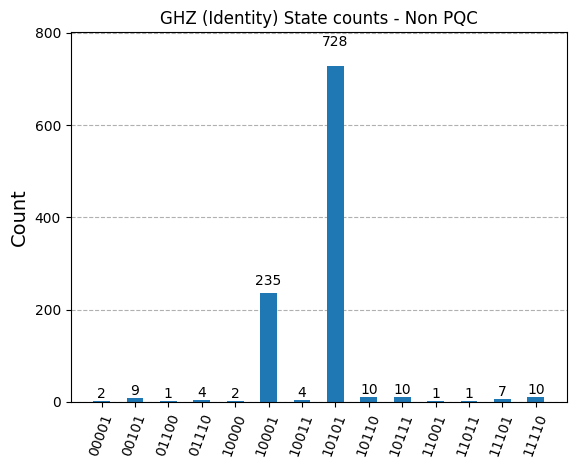

In [15]:
transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')

In [16]:
from simulator.simulate import run_circuit_sampler

def counts_to_probs(counts: torch.Tensor) -> torch.Tensor:
    """Convert integer counts to a normalized probability vector."""
    return counts.float() / counts.sum()

def fidelity(p, q):
    return torch.square(torch.sqrt(p * q).sum())

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.raw_params

ideal_data_test = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=20)

for param, ideal in ideal_data_test:
    noisy_circ = ghz_circuit_gen.get_noisy_model_circuit_params(params=param)
    noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, pqc_arch)

    counts_noisy = run_circuit_sampler(noisy_circ.measure_all(inplace=False))
    counts_noisy_pqc = run_circuit_sampler(noisy_circ_pqc)

    prob_i = counts_to_probs(ideal)
    prob_n = counts_to_probs(counts_noisy)
    prob_ne = counts_to_probs(counts_noisy_pqc)

    fid_i_n = fidelity(prob_i, prob_n)
    fid_i_ne = fidelity(prob_i, prob_ne)

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

    

Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 485.67it/s]


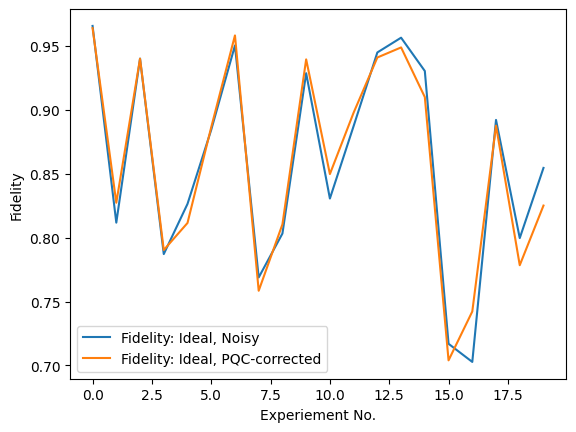

In [17]:
x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

In [18]:
torch.save(pqc_model.state_dict(), f'../data/torch_models/{str(pqc_model.__str__())}_state_dict_large.pth')

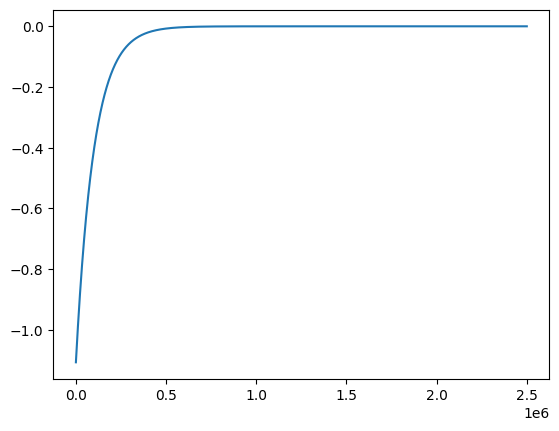

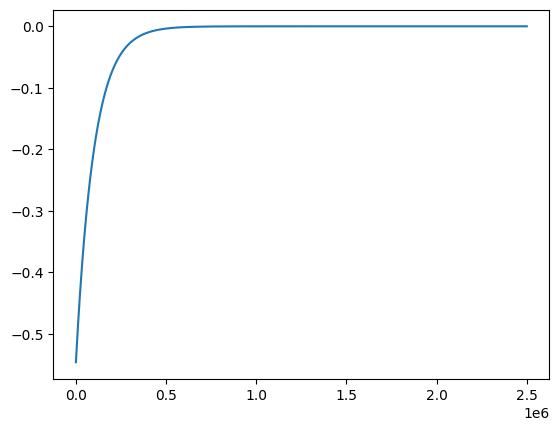

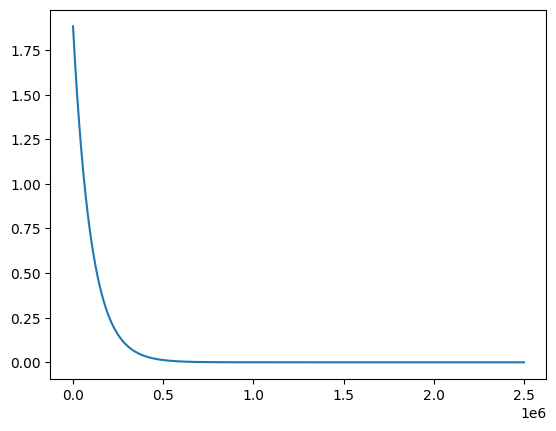

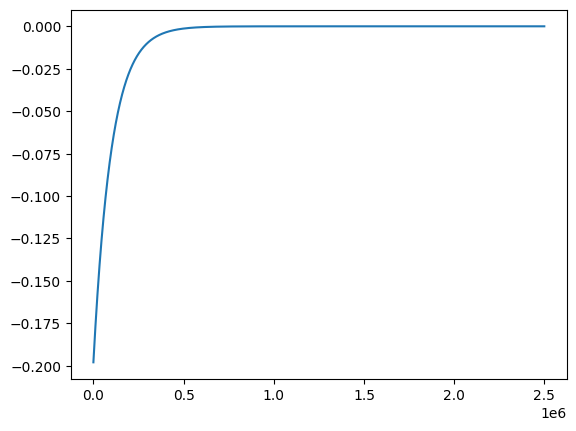

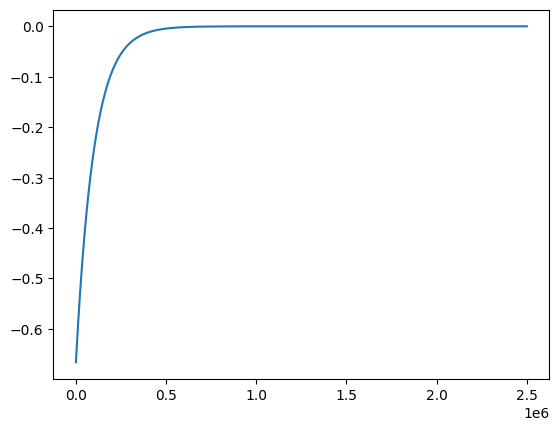

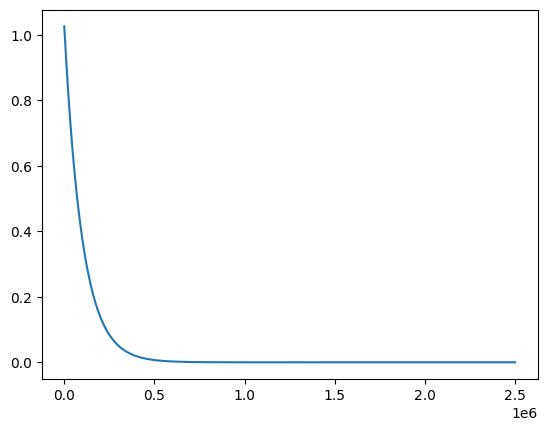

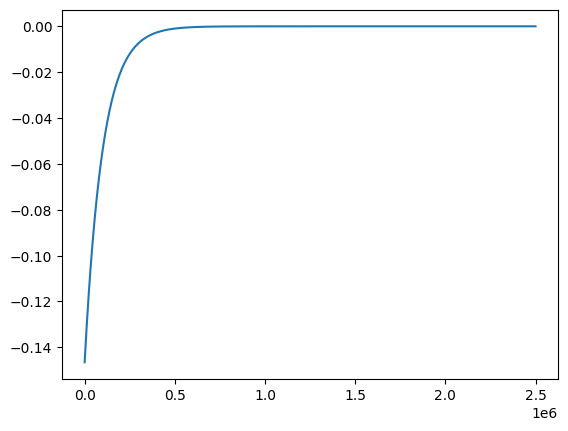

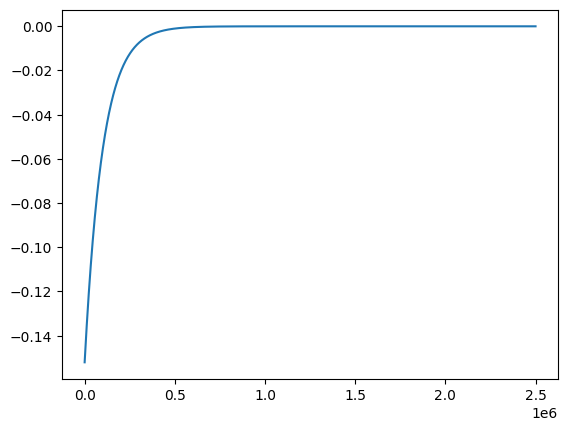

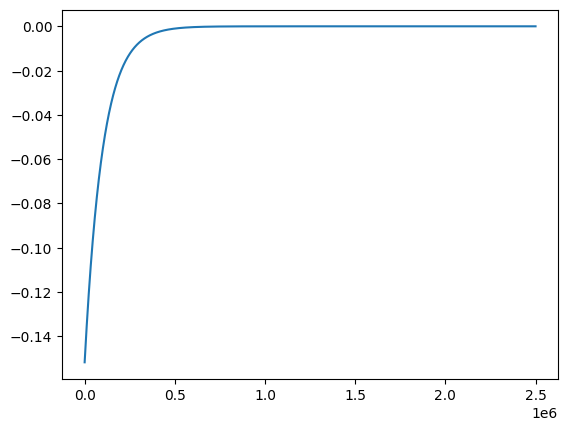

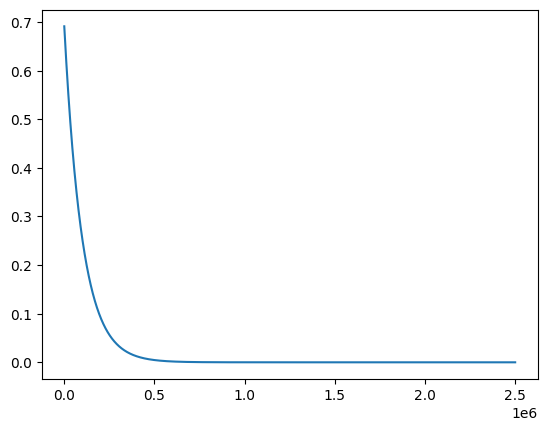

In [19]:
for pa in param_arr:
    plt.plot(range(len(pa)), pa)
    plt.show()